<a href="https://colab.research.google.com/github/kimtomato/FL_KCN-project/blob/master/DP_FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet --upgrade tensorflow_federated_nightly
!pip install --quiet --upgrade nest_asyncio

import nest_asyncio
nest_asyncio.apply()


In [ ]:
import collections

import numpy as np
import pandas as pd


In [ ]:
import tensorflow as tf
import tensorflow_federated as tff
import tensorflow_privacy as tfp

In [ ]:
#데이터 다운로드 ,전처리
def get_emnist_dataset():
  emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data(
      only_digits=True)

  def element_fn(element):
    return collections.OrderedDict(
        x=tf.expand_dims(element['pixels'], -1), y=element['label'])

  def preprocess_train_dataset(dataset):
    # Use buffer_size same as the maximum client dataset size,
    # 418 for Federated EMNIST
    return (dataset.map(element_fn)
                   .shuffle(buffer_size=418)
                   .repeat(1)
                   .batch(32, drop_remainder=False))

  def preprocess_test_dataset(dataset):
    return dataset.map(element_fn).batch(128, drop_remainder=False)

  emnist_train = emnist_train.preprocess(preprocess_train_dataset)
  emnist_test = preprocess_test_dataset(
      emnist_test.create_tf_dataset_from_all_clients())
  return emnist_train, emnist_test

train_data, test_data = get_emnist_dataset()

In [ ]:
# 모델 정의 
def my_model_fn():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Reshape(input_shape=(28, 28, 1), target_shape=(28 * 28,)),
      tf.keras.layers.Dense(200, activation=tf.nn.relu),
      tf.keras.layers.Dense(200, activation=tf.nn.relu),
      tf.keras.layers.Dense(10)])
  return tff.learning.from_keras_model(
      keras_model=model,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      input_spec=test_data.element_spec,
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
# noise 결정    Federated_learning
# 클라이언트 하나의 최대 영향을 제한

tff.backends.native.set_local_execution_context(clients_per_thread=5)

total_clients = len(train_data.client_ids)

def train(rounds, noise_multiplier, clients_per_round, data_frame):
  
  aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(
      noise_multiplier, clients_per_round)

  # We use Poisson subsampling which gives slightly tighter privacy guarantees
  # compared to having a fixed number of clients per round. The actual number of
  # clients per round is stochastic with mean clients_per_round.
  sampling_prob = clients_per_round / total_clients

  # Build a federated averaging process.
  # Typically a non-adaptive server optimizer is used because the noise in the
  # updates can cause the second moment accumulators to become very large
  # prematurely.
  learning_process = tff.learning.build_federated_averaging_process(
        my_model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.01),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0, momentum=0.9),
        model_update_aggregation_factory=aggregation_factory)

  eval_process = tff.learning.build_federated_evaluation(my_model_fn)

  # Training loop.
  state = learning_process.initialize()
  for round in range(rounds):
    if round % 5 == 0:
      metrics = eval_process(state.model, [test_data])['eval']
      if round < 25 or round % 25 == 0:
        print(f'Round {round:3d}: {metrics}')
      data_frame = data_frame.append({'Round': round,
                                      'NoiseMultiplier': noise_multiplier,
                                      **metrics}, ignore_index=True)

    # Sample clients for a round. Note that if your dataset is large and
    # sampling_prob is small, it would be faster to use gap sampling.
    x = np.random.uniform(size=total_clients)
    sampled_clients = [
        train_data.client_ids[i] for i in range(total_clients)
        if x[i] < sampling_prob]
    sampled_train_data = [
        train_data.create_tf_dataset_for_client(client)
        for client in sampled_clients]

    # Use selected clients for update.
    state, metrics = learning_process.next(state, sampled_train_data)

  metrics = eval_process(state.model, [test_data])['eval']
  print(f'Round {rounds:3d}: {metrics}')
  data_frame = data_frame.append({'Round': rounds,
                                  'NoiseMultiplier': noise_multiplier,
                                  **metrics}, ignore_index=True)

  return data_frame

In [ ]:
data_frame = pd.DataFrame()
rounds = 100
clients_per_round = 50

for noise_multiplier in [0.0, 0.5, 0.75, 1.0]:
  print(f'Starting training with noise multiplier: {noise_multiplier}')
  data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)
  print()

Starting training with noise multiplier: 0.0
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.10601979), ('loss', 2.508277)])
Round   5: OrderedDict([('sparse_categorical_accuracy', 0.19124706), ('loss', 2.2182157)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.28365007), ('loss', 2.1173127)])
Round  15: OrderedDict([('sparse_categorical_accuracy', 0.4481779), ('loss', 1.92591)])
Round  20: OrderedDict([('sparse_categorical_accuracy', 0.5412911), ('loss', 1.697358)])
Round  25: OrderedDict([('sparse_categorical_accuracy', 0.7043495), ('loss', 1.4522421)])
Round  50: OrderedDict([('sparse_categorical_accuracy', 0.7454203), ('loss', 0.8247532)])
Round  75: OrderedDict([('sparse_categorical_accuracy', 0.7736824), ('loss', 0.71542895)])
Round 100: OrderedDict([('sparse_categorical_accuracy', 0.80272824), ('loss', 0.6221913)])

Starting training with noise multiplier: 0.5
Round   0: OrderedDict([('sparse_categorical_accuracy', 0.10202782), ('loss', 2.768782)])
Round   5: OrderedDict([('sparse_categorical_accuracy

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
def make_plot(data_frame):
  plt.figure(figsize=(15, 5))

  dff = data_frame.rename(
      columns={'sparse_categorical_accuracy': 'Accuracy', 'loss': 'Loss'})

  plt.subplot(121)
  sns.lineplot(data=dff, x='Round', y='Accuracy', hue='NoiseMultiplier', palette='dark')
  plt.subplot(122)
  sns.lineplot(data=dff, x='Round', y='Loss', hue='NoiseMultiplier', palette='dark')

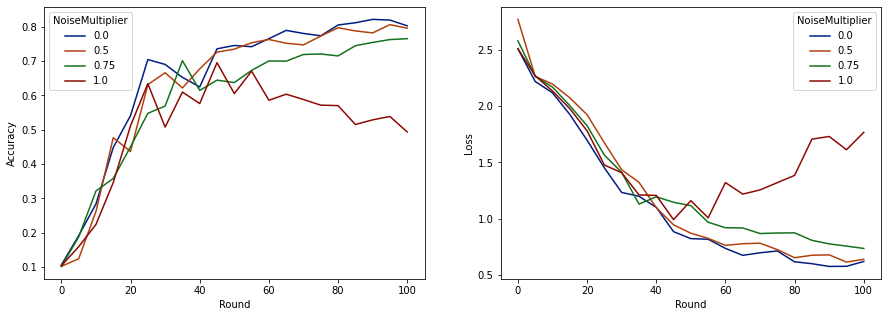

In [ ]:
make_plot(data_frame)

0.5 : 모델의 품질을 저하시키지 않으면서 noise 섞는 것이 가능 


In [ ]:
#tensorflow 사용, 필요한 라운드 당 예상 클라이언트 수 결정 가능 
# 일반적으로 dataset의 레코드 수의 1보다 약간 작은 delta 선택 
# 해당 데이터에는 3383명의 훈련사용자 존재, (2,1e-5)-DP 목표 
rdp_orders = ([1.25, 1.5, 1.75, 2., 2.25, 2.5, 3., 3.5, 4., 4.5] +
              list(range(5, 64)) + [128, 256, 512])

total_clients = 3383
base_noise_multiplier = 0.5
base_clients_per_round = 50
target_delta = 1e-5
target_eps = 2

def get_epsilon(clients_per_round):
 
  q = clients_per_round / total_clients
  noise_multiplier = base_noise_multiplier
  noise_multiplier *= clients_per_round / base_clients_per_round
  rdp = tfp.compute_rdp(
      q, noise_multiplier=noise_multiplier, steps=rounds, orders=rdp_orders)
  eps, _, _ = tfp.get_privacy_spent(rdp_orders, rdp, target_delta=target_delta)
  return clients_per_round, eps, noise_multiplier

def find_needed_clients_per_round():
  hi = get_epsilon(base_clients_per_round)
  if hi[1] < target_eps:
    return hi

  # Grow interval exponentially until target_eps is exceeded.
  while True:
    lo = hi
    hi = get_epsilon(2 * lo[0])
    if hi[1] < target_eps:
      break

  # Binary search.
  while hi[0] - lo[0] > 1:
    mid = get_epsilon((lo[0] + hi[0]) // 2)
    if mid[1] > target_eps:
      lo = mid
    else:
      hi = mid

  return hi

clients_per_round, _, noise_multiplier = find_needed_clients_per_round()
print(f'To get ({target_eps}, {target_delta})-DP, use {clients_per_round} '
      f'clients with noise multiplier {noise_multiplier}.')

To get (2, 1e-05)-DP, use 120 clients with noise multiplier 1.2.


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.088606976), ('loss', 2.4822454)])
Round   5: OrderedDict([('sparse_categorical_accuracy', 0.16685443), ('loss', 2.2306612)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.320337), ('loss', 2.1258643)])
Round  15: OrderedDict([('sparse_categorical_accuracy', 0.44572884), ('loss', 1.9539251)])
Round  20: OrderedDict([('sparse_categorical_accuracy', 0.5538303), ('loss', 1.7379986)])
Round  25: OrderedDict([('sparse_categorical_accuracy', 0.6842917), ('loss', 1.4936157)])
Round  50: OrderedDict([('sparse_categorical_accuracy', 0.7700088), ('loss', 0.789287)])
Round  75: OrderedDict([('sparse_categorical_accuracy', 0.78499705), ('loss', 0.68235946)])
Round 100: OrderedDict([('sparse_categorical_accuracy', 0.8075774), ('loss', 0.6178199)])


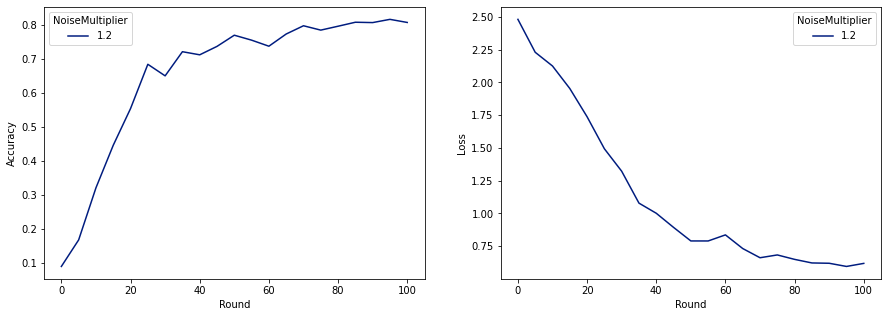

In [ ]:
rounds = 100
noise_multiplier = 1.2
clients_per_round = 120

data_frame = pd.DataFrame()
data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)

make_plot(data_frame)